In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import os

**Check if run on GPU**

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13135870812787984403, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3188244480
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11604645784071900769
 physical_device_desc: "device: 0, name: Quadro M2200, pci bus id: 0000:01:00.0, compute capability: 5.2"]

In [55]:
# setup up data related functions
# import MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# define shuffle batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[idx]
        y_batch = y[idx]
        ## Yield instead of Return: yield can resume what this function left off in the last call.
        yield X_batch, y_batch

## 1. Different Activation Functions comparison

### Logit function (may easily saturated)

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

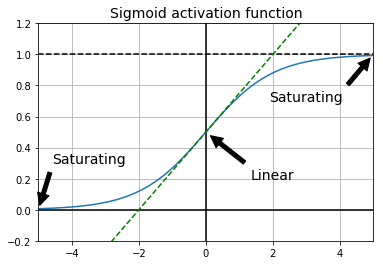

In [4]:
xx = np.linspace(-5, 5, 100)
yy = logit(xx)
plt.plot(xx, yy)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3, 0.7), xy=(5,1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Leaky ReLu

In [5]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

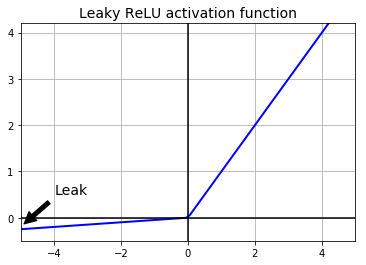

In [7]:
plt.plot(xx, leaky_relu(xx, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

leaky_relu in TensorFlow 

In [ ]:
# in TensorFlow 
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden_layer = tf.layers.dense(X, n_hidden_nueron, activation=leaky_relu, name='hidden_layer')

### ELU (always try ELU before logit)

In [8]:
def elu(z, alpha=1):
    # np.where(condition, [a, b]) : if condition --> return a /// else: b
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

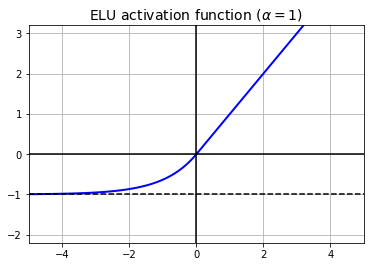

In [10]:
plt.plot(xx, elu(xx), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

ELU in TensorFlow (`tf.nn.elu`)

In [ ]:
hidden_layer = tf.layers.dense(X, n_hidden_nueron, activation=tf.nn.elu, name='hidden_layer')

### SELU 
Described in the paper [1706.Self-Normalizing Neural Networks](https://arxiv.org/pdf/1706.02515.pdf) <br>
During training, a neural network composed of a stack of dense layers using the SELU activation function will **self-normalize**: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. 
<br>As a result, this activation function **outperforms the other activation functions very significantly** for such neural nets.

In [13]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

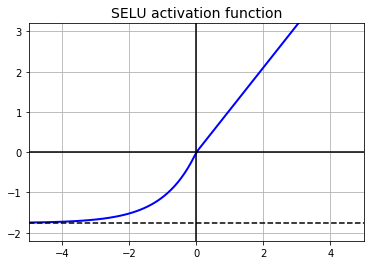

In [15]:
plt.plot(xx, selu(xx), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too) --> Need to **input Normalized Feature** before SELU. <br>Using this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [16]:
np.random.seed(54321)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.37 < mean < 0.33, 0.74 < std deviation < 1.26
Layer 10: -0.25 < mean < 0.30, 0.70 < std deviation < 1.32
Layer 20: -0.27 < mean < 0.18, 0.71 < std deviation < 1.23
Layer 30: -0.35 < mean < 0.42, 0.72 < std deviation < 1.21
Layer 40: -0.21 < mean < 0.19, 0.77 < std deviation < 1.35
Layer 50: -0.18 < mean < 0.24, 0.71 < std deviation < 1.30
Layer 60: -0.26 < mean < 0.29, 0.73 < std deviation < 1.26
Layer 70: -0.20 < mean < 0.24, 0.72 < std deviation < 1.19
Layer 80: -0.14 < mean < 0.18, 0.78 < std deviation < 1.24
Layer 90: -0.35 < mean < 0.31, 0.75 < std deviation < 1.20


SELU in TensorFlow (`tf.nn.selu`)

In [ ]:
hidden_layer = tf.layers.dense(X, n_hidden_nueron, activation=tf.nn.selu, name='hidden_layer')

Cautions before using SELU:
1. However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in `tf.contrib.nn.alpha_dropout()` since TF 1.4.
<br><br>
2. Normalize input features first. <br>
`means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_normalized = (X_valid - means) / stds`

## 2. Batch Normalization
<br>
Note that in order to run batch norm just before each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

- `training = tf.placeholder_with_default(False, shape=(), name='training')` feed this placehold 'True' while training; Do not need to feed 'False' while test time (just use the Default 'False')
<br><br>
- Note: need to explicitly run the **extra update operations** needed by batch normalization (sess.run([training_op, extra_update_ops],...).


![BN_Extra_training_op](./images/BN_Extra_training_op.JPG)

In [ ]:
# Add BN before activation
training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

logits_before_bn = tf.layers.dense(bn1_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

# Extra Update Operation for BN
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})

#### To avoid repeating the same parameters over and over again, we can use Python's `partial()` function: `from functools import partial`
<br>previous code: 

In [ ]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

### after applied `partial()`

In [ ]:
from functools import partial
# set Repeating Params for the function BN
my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

*args and **kwargs in python explained: <br>
*args or **kwargs. Only the * (aesteric) is necessary. === *var and **vars. <br>
Writing *args and **kwargs is just a convention. So now lets take a look at *args first.

**the `Partial()` is defined as follow**

In [54]:
def partial(func, *args, **keywords):
    def newfunc(*fargs, **fkeywords):
        newkeywords = keywords.copy()
        newkeywords.update(fkeywords)
        return func(*(args + fargs), **newkeywords)
    newfunc.func = func
    newfunc.args = args
    newfunc.keywords = keywords
    return newfunc

base2converter = partial(int, base=2)
# add doc_description
base2converter.__doc__ = 'convert base 2 str to int'
print(int('10010', base=2))
print(base2converter('10010'))

18
18


#### Let's build a neural net for MNIST (using ELU activation + BN): 

In [63]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [64]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8908
1 Validation accuracy: 0.9192
2 Validation accuracy: 0.93
3 Validation accuracy: 0.937
4 Validation accuracy: 0.9448
5 Validation accuracy: 0.949
6 Validation accuracy: 0.9548
7 Validation accuracy: 0.9606
8 Validation accuracy: 0.961
9 Validation accuracy: 0.965
10 Validation accuracy: 0.966
11 Validation accuracy: 0.9668
12 Validation accuracy: 0.9684
13 Validation accuracy: 0.9692
14 Validation accuracy: 0.9692
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9712
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.9728
19 Validation accuracy: 0.9718


#### Remember the BN improves considerably for **Deeper Networks**
What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. 
<br>If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [61]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [62]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### 3. Gradient Clipping (not used that much now)
Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [67]:
tf.reset_default_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:

In [69]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

the rest would be the same as before

In [70]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.46
1 Validation accuracy: 0.8226
2 Validation accuracy: 0.8842
3 Validation accuracy: 0.903
4 Validation accuracy: 0.9168
5 Validation accuracy: 0.9244
6 Validation accuracy: 0.932
7 Validation accuracy: 0.934
8 Validation accuracy: 0.9392
9 Validation accuracy: 0.9446
10 Validation accuracy: 0.947
11 Validation accuracy: 0.9498
12 Validation accuracy: 0.9506
13 Validation accuracy: 0.9522
14 Validation accuracy: 0.9546
15 Validation accuracy: 0.9568
16 Validation accuracy: 0.9584
17 Validation accuracy: 0.9582
18 Validation accuracy: 0.9616
19 Validation accuracy: 0.9602


## 4. Xavier and He Initialization
```python
he_init = tf.contrib.layers.variance_scaling_initializer()` <br>
`xavier_init = tf.contrib.layers.xavier_initializer()`<br><br>
```
then, set the kernel_initializer = xx_init <br>
```python
hidden_layer = tf.layers.dense(X, n_hidden_nueron, activation=tf.nn.selu
                               kernel_initializer=he_init, name='hidden_layer')```

#### In TensorFlow, `kernel` means weights; `bias` means biases.

In [51]:
tf.reset_default_graph()
XX = tf.placeholder(dtype=tf.float32, shape=(None,10), name='XX')

hidden1 = tf.layers.dense(XX, 10, activation=tf.nn.relu, name="hidden1")

[var.name for var in tf.trainable_variables()]

['hidden1/kernel:0', 'hidden1/bias:0']